In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import image

# Data crunching libraries
import numpy as np
import pandas as pd

# All utilities
import datetime
import time
import os
import zipfile
import sys
import re
import glob
import cv2
import PIL
import gdown

# SK-learn libraries for learning.
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# Handle parquet files
import pyarrow as pa
import pyarrow.parquet as pq
import gc

# Tensor Flow requirements
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

87000


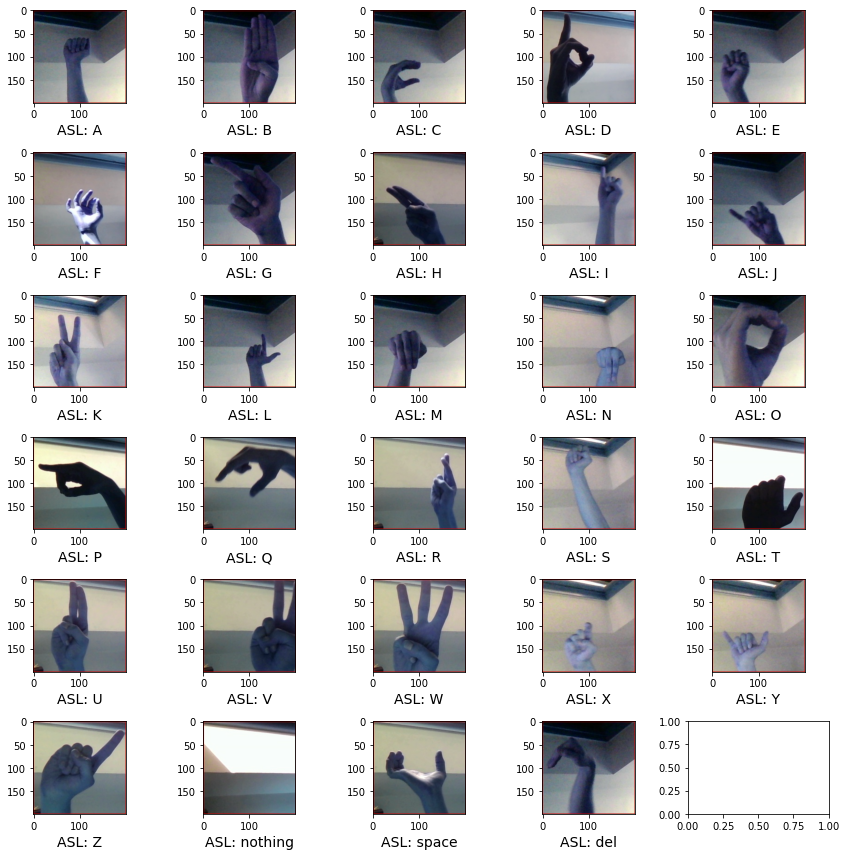

In [34]:
path = '/home/jupyter/w207/ASL_Data_40K/archive_40k/asl_alphabet_train/asl_alphabet_train/'
y_train = []
X_train = []
counter = 0
labels = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P",
          "Q","R","S","T","U","V","W","X","Y","Z","nothing","space", "del"]

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 12))
row = 0
col = 0
raw_image_list = []
c0_hist_list = []
c1_hist_list = []
c2_hist_list = []

label_ind_dict = {} # dictionary to hold the label to index mapping

for label in labels:
    # get a list of all images (.jpg files) in a directory using glob.glob
    examples = glob.glob(path+label+"/*.jpg")
    img_cnt = 0 # for each label start with img_cnt set to 0
    print_flag = np.random.randint(0, len(examples)-1) # randomly select an image to print
    for image in examples:
        y_train.append(label)
        image1 = cv2.imread(image)
        if print_flag == img_cnt: 
            raw_image_list.append(image1) # add the image to the raw_image_list
            label_ind_dict[label] = img_cnt - 1 # save the index for that label
            # calculate the RGB values for the image and append to a list
            c0_hist_list.append(cv2.calcHist([image1], [0], None, [256], [0,256]))
            c1_hist_list.append(cv2.calcHist([image1], [1], None, [256], [0,256]))
            c2_hist_list.append(cv2.calcHist([image1], [2], None, [256], [0,256]))
            ax = axes[row, col]
            ax.imshow(image1, cmap="gray") 
            ax.set_xlabel('ASL: '+label, fontsize=14) 
            col += 1
            if col % 5 == 0:
                row += 1
                col = 0
        img_cnt += 1
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        # gaussian blur
        image1 = cv2.GaussianBlur(image1.reshape(200,200), (5,5),0)
        image1 = cv2.Canny(image=image1.reshape(200,200), threshold1=100, threshold2=200)
        im_array = np.asarray(image1).reshape((200,200))
        X_train.append(im_array.flatten())
        counter += 1
        
print(len(X_train))
fig.tight_layout()
plt.show()

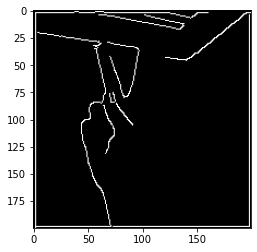

In [39]:
# check how the gray shades images show - pick a random one
plt.rc('image', cmap='gray')
plt.imshow(X_train[np.random.randint(1, len(X_train))].reshape(200,200))
plt.show()

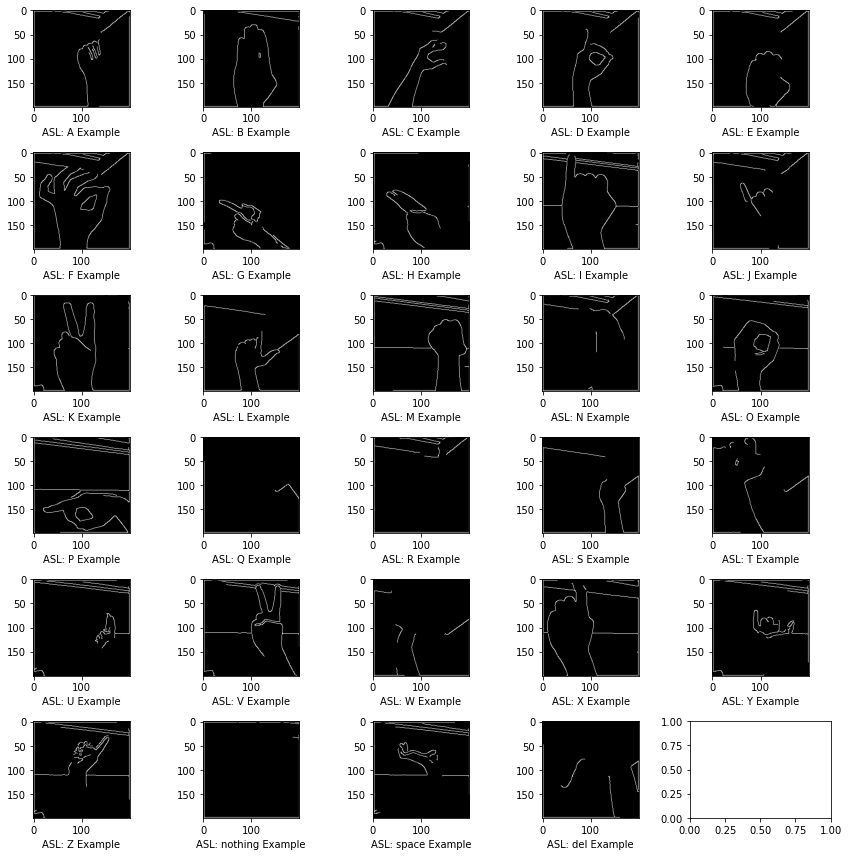

In [36]:
X_train = np.array(X_train)
y_train = np.array(y_train)
#labels = list(set(y_train))
examples = np.array(X_train)

image_index_list = [] # init list to add digit example indexes to
# for each label find indices in y_train for that label and pick that index that
# corresponds to label index that was printed earlier.
for label in labels:
    label_ind = np.where(y_train==label)[0][label_ind_dict[label]]
    image_index_list.append(label_ind)
    
plt.rc('image', cmap='gray')
fig, ax = plt.subplots(6, 5, figsize=(12,12))

counter = 0 # counter to be used for image index

for i in range(6):
    for num in range(5):
        if counter < 29:
            ind = image_index_list[counter]
            # Displaying image on correct subplot
            ax[i, num].imshow(X_train[ind].reshape(200,200))
            ax[i,num].set_xlabel('ASL: '+y_train[ind]+' Example')
            counter += 1

fig.tight_layout()
plt.show()

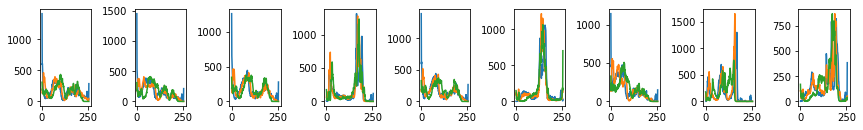

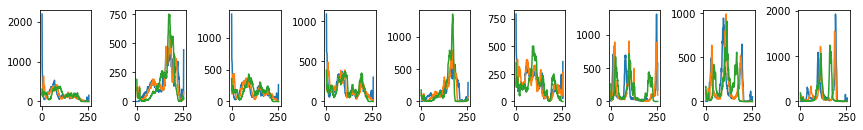

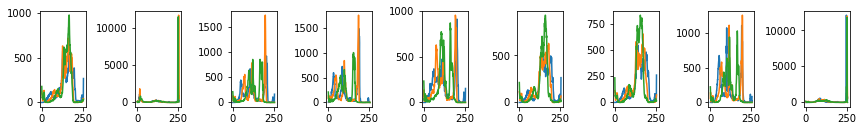

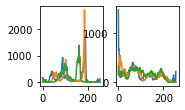

In [37]:
pos = 790 # control the positio of where we want to print the image
plt.figure(figsize=(12,12))
for i in range(len(raw_image_list)):
    pos += 1 # start with position 791 - 9 images per row, starting from column 1
    plt.subplot(pos), plt.plot(c0_hist_list[i]), plt.plot(c1_hist_list[i]), plt.plot(c2_hist_list[i])
    if pos == 799: # when 9 pictures have been accumulated
        pos = 790  # reset to 790, draw 
        plt.tight_layout() 
        plt.show() # draw the 9 pictures
        plt.figure(figsize=(12,12)) # reinit the drawing space

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path, labels=labels, batch_size=32, image_size=(200,200), 
    seed=123, validation_split=0.2, subset='training')

In [24]:
url = 'https://drive.google.com/uc?id=1S-z8nvTAYeBwRsQCGAlDloooNqt31T8M'
outfile = 'X_label.csv'
gdown.download(url, outfile)

Downloading...
From: https://drive.google.com/uc?id=1S-z8nvTAYeBwRsQCGAlDloooNqt31T8M
To: /home/jupyter/w207/X_label.csv
100%|██████████| 297k/297k [00:00<00:00, 55.3MB/s]


'X_label.csv'

In [27]:
url = 'https://drive.google.com/uc?id=1qtzN3qcusdHCe2zcM-hgXW19lW8FsHr8'
outfile = 'X_train.pq'
start_time = time.time()
gdown.download(url, outfile)
print("Time taken:", time.time() - start_time)

Downloading...
From: https://drive.google.com/uc?id=1qtzN3qcusdHCe2zcM-hgXW19lW8FsHr8
To: /home/jupyter/w207/X_train.pq
100%|██████████| 3.27G/3.27G [00:26<00:00, 122MB/s] 


Time taken: 41.57634711265564


In [ ]:
start_time = time.time()
table = pq.read_table('X_train.pq')
print("Time taken:", time.time() - start_time)

In [ ]:
start_time = time.time()
table = table.to_pandas().to_numpy()
print("Time taken: ", time.time() - start_time)
print(len(table))
print(len(table[0]))

In [ ]:
plt.rc('image', cmap='gray')
plt.imshow(table[0].reshape(200,200))
plt.show()